In [1]:
import pandas as pd
import csv, re, html
from nltk.corpus import stopwords

In [2]:
papers_file = './data/papers_22072019.csv.xz'
works_file  = './data/works_22072019.csv.xz'

## Abrindo Artigos e Trabalhos

In [3]:
df_papers = pd.read_csv(papers_file, sep='|', compression='xz')
df_papers.drop(df_papers.loc[df_papers['idioma']=='Português'].index, inplace=True)
df_papers.drop(['id_doc','autores_cnpq','autores','idioma','revista','natureza'], axis=1, inplace=True)
df_papers.dropna(inplace=True)

In [4]:
df_works = pd.read_csv(works_file, sep='|', compression='xz')
df_works.drop(df_works.loc[df_works['idioma']=='Português'].index, inplace=True)
df_works.drop(['id_doc','autores_cnpq','autores','idioma','anais','natureza'], axis=1, inplace=True)
df_works.dropna(inplace=True)

In [5]:
del [papers_file, works_file]

## Concatenando Dataframe

In [6]:
frames = [df_papers, df_works]
df_lattes = pd.concat(frames)
df_lattes.sort_values(by=['id','ano'], ignore_index=True, inplace=True)

In [7]:
del [frames, df_papers, df_works]

## Seleciona Ano

In [8]:
df_lattes.drop(df_lattes.loc[~df_lattes['ano'].astype(str).str.isnumeric()].index, inplace=True)
df_lattes['ano'] = df_lattes['ano'].astype(int)
df_lattes.shape


(186728, 3)

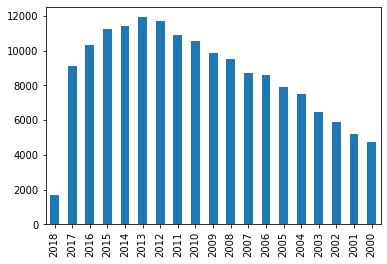

In [9]:
ano_docs = df_lattes['ano'].value_counts().sort_index(ascending=False).head(19)
ano_docs.plot(kind='bar')

In [10]:
select_year = 2017

df_lattes.drop(df_lattes.loc[df_lattes['ano']!=select_year].index, inplace=True)
df_lattes.drop(['ano'], axis=1, inplace=True)
df_lattes.sort_values(by=['id'], ignore_index=True, inplace=True)
df_lattes.shape

(9130, 2)

## Concatena Autor

In [11]:
df_lattes = df_lattes.groupby('id', sort=False).titulo.apply(' '.join).reset_index(name='titulo')
df_lattes.shape

(3111, 2)

## Remove Tags HTML

In [12]:
def decode_html(text):
    decoded = html.unescape(text)
    return decoded

def remove_tags1(text):
    clean = re.compile(r'(<!--.*?-->|<[^>]*>)')
    cleantext = re.sub(clean, '', text)
    return cleantext

def remove_tags2(text):
    clean = re.compile('{.*?}')
    cleantext = re.sub(clean, '', text)
    return cleantext

df_lattes['titulo'] = df_lattes['titulo'].apply(decode_html)
df_lattes['titulo'] = df_lattes['titulo'].apply(remove_tags1)
#df_lattes['titulo'] = df_lattes['titulo'].apply(remove_tags2)

## Remove Stopwords

In [13]:
sw = stopwords.words('english')
sw_extra_file = open('./data/stopwords_extra.txt','r')
sw_extra = sw_extra_file.read().splitlines()

def remove_bar(text):
    clean = re.compile('(?:\/+)')
    cleantext = re.sub(clean, ' ', text)
    return cleantext

def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def stopwords_extra(text):
    new_title = []
    for word in text:
        if word not in sw_extra:
            new_title.append(word)
    return new_title

df_lattes['titulo'] = df_lattes['titulo'].apply(remove_bar)
df_lattes['titulo'] = df_lattes['titulo'].apply(stopwords)
#df_lattes['titulo'] = df_lattes['titulo'].apply(stopwords_extra)
df_lattes.dropna(inplace=True)

## Remove Pontuação

In [14]:
def remove_punctuation(text):
    delete  = '":()!,;$?\'-+=%#\%[]'
    table = text.maketrans('', '', delete)
    return text.translate(table)

df_lattes['titulo'] = df_lattes['titulo'].apply(remove_punctuation)

## Remove Noise

In [15]:
def remove_endptr(text):
    clean = re.compile('(?:\s*\.+)\Z')
    cleantext = re.sub(clean, '', text)
    return cleantext

def remove_strptr(text):
    clean = re.compile('\.\s')
    cleantext = re.sub(clean, ' ', text)
    return cleantext

def remove_spaces(text):
    return " ".join(text.split())

df_lattes['titulo'] = df_lattes['titulo'].apply(remove_endptr)
df_lattes['titulo'] = df_lattes['titulo'].apply(remove_strptr)
df_lattes['titulo'] = df_lattes['titulo'].apply(remove_spaces)

## Salva CSV

In [16]:
ida_file = './data/out/%dauthors.csv.xz' % select_year
dev_file = './data/out/%dpreprocess.csv' % select_year
pre_file = './data/out/%dpreprocess.csv.xz' % select_year

df_lattes.to_csv(ida_file, index=None, compression='xz', columns = ['id'])
df_lattes.to_csv(pre_file, index=None, compression='xz', columns = ['titulo'])
df_lattes.to_csv(dev_file, index=None, columns = ['titulo'])